In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from ssim import *
import torch
import torch.fft as fft
def add_gaussian_noise(image, mean=0, sigma=25):

    row, col, ch = image.shape
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    noisy_image = np.clip(image + gauss, 0, 255).astype(np.uint8)
    return noisy_image

def SNR_to_noise(snr):
    snr = 10 ** (snr / 10)
    noise_std = 1 / np.sqrt(2 * snr)
    return noise_std


def AWGN(Tx_sig, n_var,device):
    Rx_sig = Tx_sig + torch.normal(0, n_var, size=Tx_sig.shape).to(device)
    return Rx_sig



In [3]:
device = 'cuda:2'
conf =ffhq128_autoenc_72M()
#conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Seed set to 0


Model params: 122.59 M


128


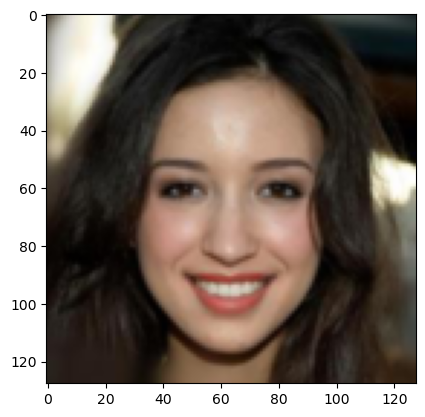

In [5]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
print(data)
batch = data[0]['img'][None]   #[0]

import matplotlib.pyplot as plt

# 获取原始图像的像素大小
width, height = batch[0].permute([1, 2, 0]).shape[1], batch[0].permute([1, 2, 0]).shape[0]
print(width)
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

from PIL import Image
import numpy as np
# 将Tensor转换为NumPy数组，并将像素值缩放到0到1的范围内
image_data = (batch[0].permute([1, 2, 0]).cpu().numpy() / 2 + 0.5).clip(0, 1)
# 将NumPy数组转换为PIL图像对象
image = Image.fromarray((image_data * 255).astype(np.uint8))
# 保存图像为JPEG格式
image.save("/home/liujian/diffae-master/output.jpg")



# Encode

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 90, 90])
torch.Size([1, 512])
torch.Size([1, 3, 90, 90])
Encoder success
Transmit success


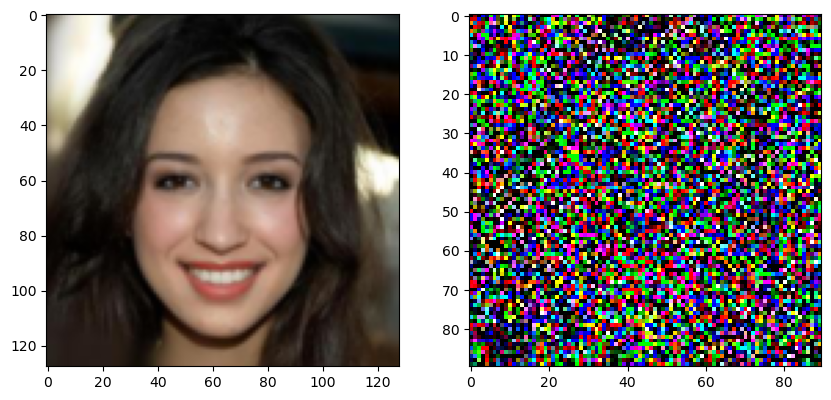

In [91]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=200)
print(cond.shape)
print(xT.shape)
print("Encoder success")   ###############完成encoder
SNR=5
noise_std=SNR_to_noise(SNR)
cond_256=AWGN(cond*256,noise_std,device)
cond=cond_256/256
xT =AWGN(xT ,noise_std,device)
print("Transmit success")
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

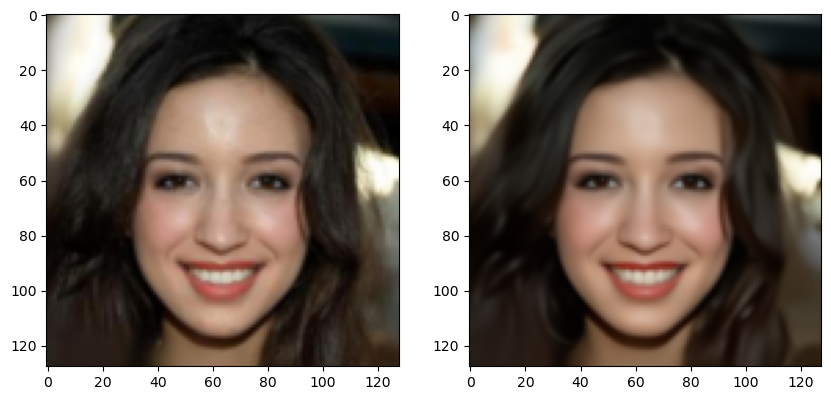

In [89]:
xT = F.interpolate(xT, size=[128,128], mode='bicubic', align_corners=False)
pred = model.render(xT, cond, T=72)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu()) 

ssim= tensor(0.9052)


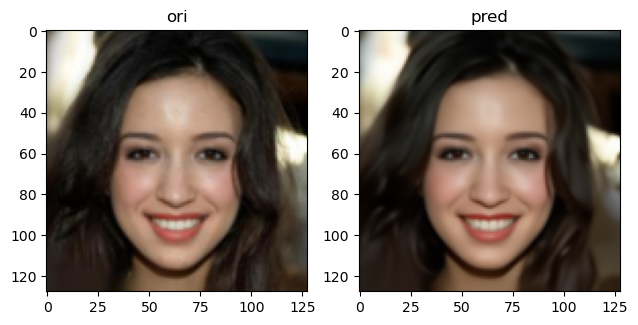

PSNR值: 29.911334737434746 dB


In [90]:
import matplotlib.pyplot as plt # plt 用于显示图片
from PIL import Image
img1 = ori[0].cpu()      #[3,128,128]
img2 = pred[0].cpu()     #[3,128,128]
ssim_score=ssim(img1,img2)
print('ssim=',ssim_score)
img1 = ori[0].permute(1, 2, 0).cpu()
img2 = pred[0].permute(1, 2, 0).cpu()
#结果展示
plt.subplot(121)
plt.imshow(img1)
plt.title('ori')
#不显示坐标轴
#plt.axis('off')
#子图2
plt.subplot(122)
plt.imshow(img2)
plt.title('pred')
#plt.axis('off')
# #设置子图默认的间距
plt.tight_layout()
#显示图像
plt.show()
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
img1_np = img1.cpu().numpy()
img2_np = img2.cpu().numpy()
# 使用 skimage 库计算 PSNR
psnr_value = peak_signal_noise_ratio(img1_np, img2_np)
print(f"PSNR值: {psnr_value} dB")


ssim= tensor(0.9170)


/tmp/ipykernel_41883/2241594652.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


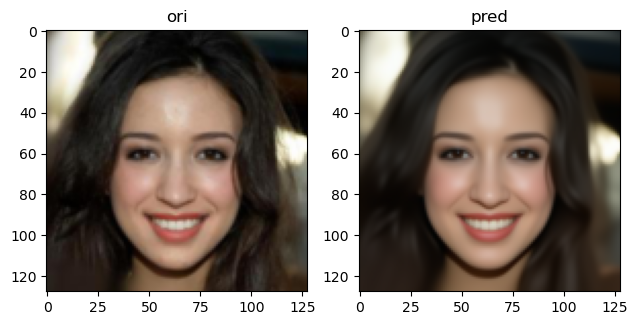

PSNR值: 31.956943633023094 dB


In [33]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch1 = data[0]['img'][None]     #0

plt.imshow(batch1[0].permute([1, 2, 0]) / 2 + 0.5)     
ori1 = (batch1 + 1) / 2   #batch1 是原图
img1 = ori1[0].cpu()      #[3,128,128]
img2 = pred[0].cpu()     #[3,128,128]
ssim_score=ssim(img1,img2)
print('ssim=',ssim_score)
img1 = ori1[0].permute(1, 2, 0).cpu()
img2 = pred[0].permute(1, 2, 0).cpu()
#结果展示
plt.subplot(121)
plt.imshow(img1)
plt.title('ori')
plt.subplot(122)
plt.imshow(img2)
plt.title('pred')
#plt.axis('off')
plt.tight_layout()
plt.show()   
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
img1_np = img1.cpu().numpy()
img2_np = img2.cpu().numpy()
# 使用 skimage 库计算 PSNR
psnr_value = peak_signal_noise_ratio(img1_np, img2_np)
print(f"PSNR值: {psnr_value} dB")

In [25]:
import torch
import lpips
from PIL import Image
#计算lpips 指标  越低越好
# 加载预训练的LPIPS模型
lpips_model = lpips.LPIPS(net="alex")
# 将图像转换为PyTorch的Tensor格式
image1_tensor = torch.tensor(np.array(img1_np)).permute(2, 0, 1).unsqueeze(0).float() / 255.0

print(image1_tensor.size())
image2_tensor = torch.tensor(np.array(img2_np)).permute(2, 0, 1).unsqueeze(0).float() / 255.0
# 使用LPIPS模型计算距离
distance = lpips_model(image1_tensor, image2_tensor)
print("LPIPS distance:", distance.item())



Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/liujian/anaconda3/envs/msc39/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
torch.Size([1, 3, 128, 128])
LPIPS distance: 7.144865890040819e-07
